In [2]:
#Import packages
import numpy as np
import pandas as pd
from basic_utils import *
import plotly.express as px
from statistics import mean
from scipy.stats import spearmanr

#Load data
data_original = np.load("/Users/christianbutcher/Documents/Local Docs/Thesis/Data/M2_matrix.npy")
mz_vector = np.load("/Users/christianbutcher/Documents/Local Docs/Thesis/Data/M2_mz_vector.npy")
row2grid = np.load("/Users/christianbutcher/Documents/Local Docs/Thesis/Data/M2_row2grid.npy")

data = np.copy(data_original)
data[data <= 0] = 0
residual = np.copy(data_original)
residual[residual > 0] = 0

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
#Obtain change values

indices_iter = iter(range(len(mz_vector)-5))
change_values = []

for i in indices_iter:
    indices = range(i,i+6)


    ##max_intensities = []
    ##new_max_intensity = max(data[:,indices[5]])

    matrix_distances = []

    new_pixel = make_image(row2grid, data[:,indices[5]])

    for j in indices[0:5]:
        #Look for change in max intensity
        ##max_intensities += [max(data[:,j])]

        #Look at 'distance' between pixel matrices
        pixel = make_image(row2grid, data[:,j])
        matrix_distance = np.linalg.norm(new_pixel-pixel)
        matrix_distances += [matrix_distance]


    mean_matr_dist = mean(matrix_distances)
    ##max_intensity_ttest = ttest_ind(max_intensities, new_max_intensity)


    if mean_matr_dist > 150:
        change_values += [mz_vector[indices[5]]]
        next(indices_iter)
        next(indices_iter)
        next(indices_iter)
        next(indices_iter)

        
        

In [4]:
#Creating the groups of mz values based on change values

groups = []
temp_list = []

for i in range(len(mz_vector)):
    if len(np.intersect1d(mz_vector[i], change_values)) == 0:
        temp_list.append(mz_vector[i])
        
    else:
        groups.append(temp_list)
        temp_list = []
        temp_list.append(mz_vector[i])

groups.append(temp_list)

In [5]:
#For each group, calculate the mean ion image (and include min/max m/z value for each group)

representative_matr = []
for j in range(len(groups)):
    temp_matr = np.zeros((228,165))
    for i in range(len(groups[j])):
        ind = find_nearest_idx(mz_vector, groups[j][i])
        new_matr = make_image(row2grid, data[:,ind])
        temp_matr += new_matr

    temp_matr = temp_matr / len(groups[j])
    representative_matr += [[temp_matr, groups[j][0], groups[j][-1]]]

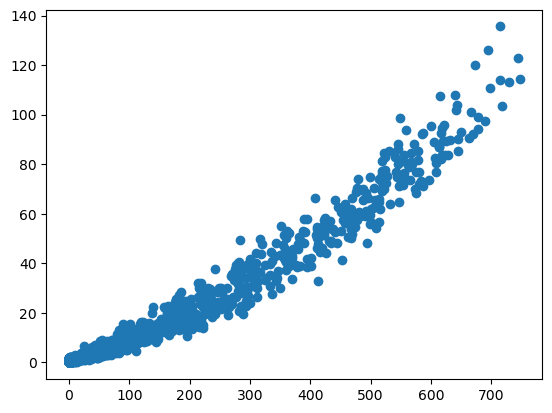

In [7]:
insulin_flat = np.ndarray.flatten(representative_matr[31][0])
i_flat = np.ndarray.flatten(representative_matr[30][0])
plt.scatter(insulin_flat, i_flat)

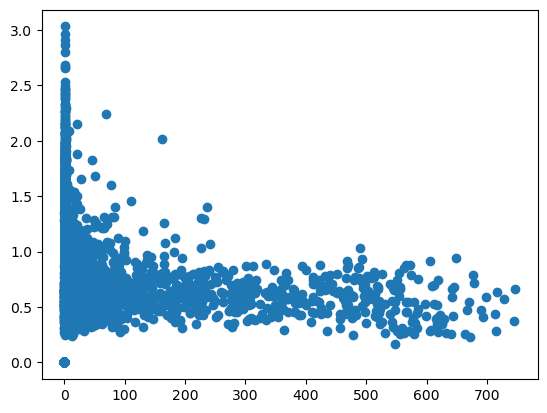

In [8]:
insulin_flat = np.ndarray.flatten(representative_matr[31][0])
i_flat = np.ndarray.flatten(representative_matr[1][0])
plt.scatter(insulin_flat, i_flat)

In [9]:
#Calculating spearman correlation between insulin group (31) and every other group
spearman_tests = []
for i in range(len(representative_matr)):
    insulin_flat = np.ndarray.flatten(representative_matr[31][0])
    spearman_temp = []
    i_flat = np.ndarray.flatten(representative_matr[i][0])

    temp_test, temp_pval = spearmanr(insulin_flat, i_flat, alternative='greater')


    spearman_tests.append([31, i, 'Group ' + str(31), 'Group ' + str(i), temp_test, np.round(temp_pval,8)])

#Plot histogram of correlations with insulin group
px.histogram([item[-2] for item in spearman_tests], nbins= 50,labels={'value':'Spearman Coefficient'} ,template='seaborn')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [17]:
#Filter for pairs with pearson coefficient of at least 0.932
correlated = [item for item in spearman_tests if abs(item[-2])>0.932]
correlated

#For each group that is correlated with insulin group, get representative m/z value by finding max Frob. norm
group_rep_mz = []
for i in range(len(correlated)):
    norms = []
    group_no = correlated[i][1]
    for j in range(len(groups[group_no])):
        ind = find_nearest_idx(mz_vector, groups[group_no][j])
        ion_im = make_image(row2grid, data[:,ind])
        fro_norm = np.linalg.norm(ion_im)
        norms += [fro_norm]
    max_norm = max(norms)
    max_index = norms.index(max_norm)

    group_rep_mz += [["Group " + str(group_no), groups[group_no][max_index]]]

In [ ]:
#Save the values
#### Make sure to rename file each time ####

# with open(r'/Users/christianbutcher/Documents/Local Docs/Thesis/Output Values/candidate_vals_150_mean_spearman', 'w') as fp:
#     for item in group_rep_mz:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

In [18]:
#Collect candidate artefact values into one object
candidate_vals = []
for i in range(len(group_rep_mz)):
    candidate_vals += [group_rep_mz[i][1]]

candidate_vals = np.asarray(candidate_vals)
candidate_vals

array([2901.44696833, 3113.78122723, 3923.22515963, 4336.31180876,
       5778.89789498, 5787.90601505, 5794.34038654, 5800.77475802,
       5802.06163231, 5808.4960038 , 5814.93037528, 5821.36474676,
       5827.79911824, 5839.38098691, 5840.66786121, 5847.10223269,
       5859.97097565, 6006.67464544, 6024.69088558])

(0.95, 1.05)

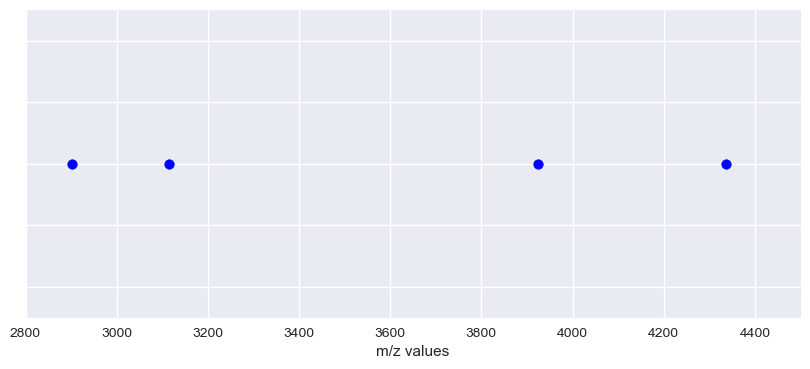

In [19]:
#Plot obtained artefact values
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,4))
plt.scatter(candidate_vals, y=np.repeat(1,len(candidate_vals)), c='blue')
plt.xlabel('m/z values')
plt.tick_params(left = False, labelleft=False)
plt.xlim(2800,4500)
plt.ylim(0.95,1.05)

(5600.0, 6100.0)

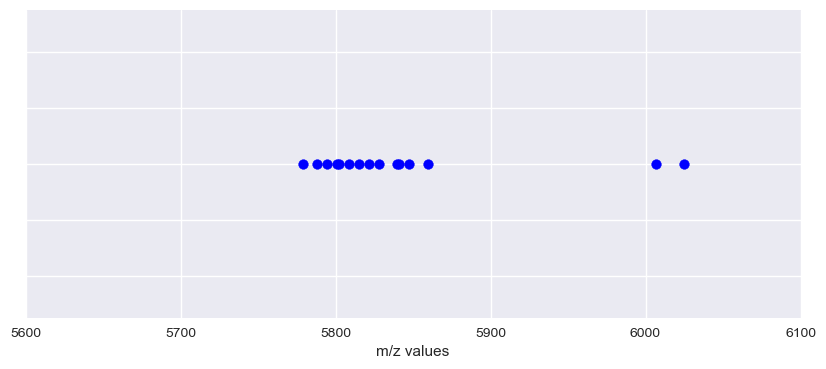

In [20]:
#Plot obtained artefact values
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,4))
plt.scatter(candidate_vals, y=np.repeat(1,len(candidate_vals)), c='blue')
plt.xlabel('m/z values')
plt.tick_params(left = False, labelleft=False)
plt.xlim(5600,6100)